# 프로젝트: ResNet Ablation Study

목표 : ResNet 논문에서 제시한 residual connection의 애블레이션 연구를 실험해보기 

## 0) 들어가며
**프로젝트 평가 기준**
<img src="./images/g1_24.png"></img>

**ResNet의 파라미터 구조**
<img src="./images/g1_23.png"></img>


## 1) ResNet 기본 블록 구성하기

*Step설명 : 우리가 지금 만들어야 하는 것은 블록을 생성하는 함수입니다. 처음이라 너무 막연하실 수 있겠지만 여러분들은 이미 몇번의 경험이 있습니다.
일단은 VGG에서도 블록을 생성하는 함수를 만들었습니다. ResNet이라 하더라도 아이디어의 기본 원리는 다르지 않습니다.*

*그리고, 여러분들은 아마 이전에 VGG-16이나 ResNet-50 모델을 만들어서 훈련까지 시켜본 경험들이 있으실 것입니다. 코드를 스스로 구현한 것이 아니라 공개된 오픈소스를 활용해서 빠르게 구성했겠지만, 블록 생성 함수가 어떤 형태로 만들어지는지를 이미 경험해 보신 바 있을 테니 그것을 참고하셔도 도움이 될 것입니다.*

*하지만 이번 단계에서는 가급적 ResNet 논문을 통해서 구현방법에 대한 정보를 얻으시기를 권합니다. 논문만 보고 스스로 구현해 보는 경험을 통해 딥러닝 개발자로서의 내공과 자신감이 다져지게 될 것입니다.* 



In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

### 1-1) 블록 함수들 생성 

In [3]:
# conv2d(7x7) 함수 
def conv2d7x7(input_layer):
    x = keras.layers.Conv2D(filters=64,
                               kernel_size=(7, 7),
                               strides=2,
                               padding="same")(input_layer)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)   
    x = keras.layers.MaxPool2D(pool_size=(3, 3),
                                  strides=2,
                                  padding="same")(x)  
    return x

In [4]:
# output 
def output_layer(output, num_classes):
    output = keras.layers.GlobalAveragePooling2D()(output)
    output = keras.layers.Dense(units=num_classes, activation=tf.keras.activations.softmax)(output)
    return output

In [5]:
# Resnet 기본 블럭
def resnet_basic_block(input_layer,
                           num_cnn=3,
                           channel=64,
                           stage_num=1,
                           strides=1,is_plain=False,):

    # input layer
    x = input_layer    
    
    # residual block  
    if strides != 1:
        residual = keras.layers.Conv2D(filters=channel,
                                kernel_size=(1,1),
                                strides=strides,
                                name=f'residual{stage_num}_conv{num_cnn}_1')(x)
        residual = keras.layers.BatchNormalization(name=f'residual{stage_num}_bn{num_cnn}')(residual)

    else:
        residual = x 
        
    # conv1 (3x3)
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=(3,3),
                            strides=strides,
                            padding='same',
                            name=f'stage{stage_num}_conv{num_cnn}_1')(x)
    x = keras.layers.BatchNormalization(name=f'stage{stage_num}_bn{num_cnn}_1')(x)
    x = keras.layers.Activation('relu')(x)
    
    # conv2 (3x3)
    x = keras.layers.Conv2D(filters=channel,
                    kernel_size=(3,3),
                    strides=1,
                    padding='same',
                    name=f'stage{stage_num}_conv{num_cnn}_2')(x)
    x = keras.layers.BatchNormalization(name=f'stage{stage_num}_bn{num_cnn}_2')(x)
    
    # residual block 추가 여부
    if not is_plain:
        x = keras.layers.Add()([residual, x])
    output = keras.layers.Activation('relu')(x)
    
    return output

In [6]:
# BottleNeck 블럭
def bottle_neck_block(input_layer,
                           num_cnn=3,
                           channel=64,
                           stage_num=1,
                           strides=1,is_plain=False,):

    # 입력 레이어
    x = input_layer

    # residual block  
    if num_cnn == 0:
        residual = keras.layers.Conv2D(filters=channel*4,
                                kernel_size=(1,1),
                                strides=strides,
                                name=f'residual{stage_num}_conv{num_cnn}_1')(x)
        residual = keras.layers.BatchNormalization(name=f'residual{stage_num}_bn{num_cnn}')(residual)

    else:
        residual = input_layer 
    
    # conv1 (1x1)
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=(1,1),
                            strides=1,
                            padding='same',
                            name=f'stage{stage_num}_conv{num_cnn}_1')(x)
    x = keras.layers.BatchNormalization(name=f'stage{stage_num}_bn{num_cnn}_1')(x)    
    x = keras.layers.Activation('relu')(x)
    
    # conv2 (3x3)
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=(3,3),
                            strides=strides,
                            padding='same',
                            name=f'stage{stage_num}_conv{num_cnn}_2')(x)
    x = keras.layers.BatchNormalization(name=f'stage{stage_num}_bn{num_cnn}_2')(x)
    x = keras.layers.Activation('relu')(x)
    
    # conv3 (1x1) 
    x = keras.layers.Conv2D(filters=channel*4,
                    kernel_size=(1,1),
                    strides=1,
                    padding='same',
                    name=f'stage{stage_num}_conv{num_cnn}_3')(x)
    x = keras.layers.BatchNormalization(name=f'stage{stage_num}_bn{num_cnn}_3')(x)
    
    # residual block 추가 여부
    if not is_plain:
        x = keras.layers.Add()([residual, x])
    output = keras.layers.Activation('relu')(x)
            
    return output

In [7]:
# resnet block 빌드하기 
def build_resnet_basic_block(input_layer,
                           num_cnn=3,
                           channel=64,
                           stage_num=1,
                           strides=1,is_plain=False,):
    
    res_block = resnet_basic_block(input_layer,
                               0,
                               channel,
                               stage_num,
                               strides, is_plain)

    for i in range(1, num_cnn):
        res_block = resnet_basic_block(res_block,
                                   i,
                                   channel,
                                   stage_num,
                                   1, is_plain)
    return res_block

In [8]:
# bottle neck block 빌드하기 
def build_bottle_neck_block(input_layer,
                           num_cnn=3,
                           channel=64,
                           stage_num=1,
                           strides=1, is_plain=False,):
    
    res_block = bottle_neck_block(input_layer,
                               0,
                               channel,
                               stage_num,
                               strides, is_plain)
    
    
    for i in range(1, num_cnn):
        res_block = bottle_neck_block(res_block,
                                   i,
                                   channel,
                                   stage_num,
                                   1, is_plain)

    return res_block

### 1-2) 모델 빌드 함수

In [9]:
# ResNet 빌드 함수 
def build_resnet(input_shape=(32, 32, 3),
                 num_cnn_list=[3, 4, 6, 3],
                 channel_list=[64,128,256,512],
                 stride_list=[1, 2, 2, 2],
                 num_classes=10,
                 is_50=False, is_plain=False):
    
    assert len(num_cnn_list) == len(channel_list)
    assert len(num_cnn_list) == len(stride_list)
    
    input_layer = keras.layers.Input(shape=input_shape)

    output = conv2d7x7(input_layer)    
    
    if not is_50:    
        for i, (num_cnn, channel, stride) in enumerate(zip(num_cnn_list, channel_list, stride_list)):
            output = build_resnet_basic_block(
                output,
                num_cnn=num_cnn,
                channel=channel,
                stage_num=i,
                strides=stride, 
                is_plain=is_plain)
    else:
        for i, (num_cnn, channel, stride) in enumerate(zip(num_cnn_list, channel_list, stride_list)):
            output = build_bottle_neck_block(
                output,
                num_cnn=num_cnn,
                channel=channel,
                stage_num=i,
                strides=stride, 
                is_plain=is_plain)
        
    output = output_layer(output, num_classes)

    model = keras.Model(inputs=input_layer, outputs=output)
    
    return model

## 2) ResNet-34, ResNet-50 Complete Model
*Step설명 : ResNet 모델 구현시 Sequential API나 Subclass API를 사용한다면, 그 과정에서 모델 단위로 기존의 코드를 재활용했을 때 model.summary() 호출시 서브모델 내부의 레이어 구성이 생략되고 서브모델 단위로만 출력될 우려가 있습니다. 모델 구성만을 위해서는 그런 방법도 무방하지만, 가급적 이번 실습에서는 VGG 실습 예시에서처럼 Functional API 를 구성하는 방식을 사용할 것을 권합니다.*   

**Residual Network 논문 설명**  
- Plan Network를 기반으로 해서 sortcut connections를 삽입하여 residual version으로 전환한다.   
- Identity Shortcut은 input과 output을 같은 차원 (same dimension)으로 맞춰야 한다.   
- 차원이 증가하면 두가지 옵션을 고려한다.  
    1) 차원을 늘리기 위해 0을 넣어서 padding 하기(같은 차원으로 만들어 주기 위해서), 추가 파라미터가 없음  
    2) projection shortcut은 차원을 일치시키는데에 사용된다. (1x1 convolutions에 의해)  
    두 옵션은 모두 sortcuts이 두 사이즈의 feature map을 가로 지르면서 stride 2로 수행된다.   
    
**building block : ResNet34와 bottleneck for ResNet-50/101/152.**
- 쌓여진 레이어가 그 다음 레이어에 바로 적합되는 것이 아니라 잔차의 mapping에 적합하도록 만들어졌다.
<img src="./images/g2_3.png"></img>


**구현상세**
- image resized 224 * 224
- Batch normalization BN 사용
- Initialize Weights
- SGD, mini batch 256
- Learning rate 0.1 (참고 : learning rate 설정에 대한 이론을 알고 싶으면 armijo rule 참고할 것, 딥러닝은 0.1,0.01,0.001의 정해진 수를 많이 씀)
- Iteration 60 * 10^4
- weight decay 0.0001, momentum 0.9
- No dropout


### ResNet-34
*Step설명 : VGG와 같이 블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어 봅시다. ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 함수에 전달해서 같은 생성 함수 build_resnet()를 통해서 ResNet의 여러가지 버전들을 모두 만들어 낼 수 있도록 해야 합니다.*

In [10]:
resnet_34 = build_resnet(input_shape=(224, 224,3), is_50=False)   
resnet_34.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [37]:
#tf.keras.utils.plot_model(resnet_34, show_shapes=True, dpi=64)

### ResNet-50
*위에서 만든 함수에 config를 조절해서 ResNet-50을 만들어 봅니다. 구조가 원하는 대로 만들어졌는지 확인하고 이상이 있다면 수정합니다.*




In [11]:
resnet_50 = build_resnet(input_shape=(224,224,3), is_50=True)  
resnet_50.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 112, 112, 64) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [38]:
#tf.keras.utils.plot_model(resnet_50, show_shapes=True, dpi=64)


## 3) 일반 네트워크(plain network) 만들기
### 블록 코드 수정하기
*Step설명 : 우리는 앞에서 ResNet 모델을 구현했습니다. ResNet의 핵심 아이디어는 skip connection과 residual network기 때문에, ResNet의 효과를 보여주기 위해서는 skip connection이 없는 일반 네트워크(plain net)가 필요합니다. 위에서 ResNet 블록을 만들기 위한 함수를 그대로 활용해서 skip connection이 없는 블록을 만들 수 있도록 기능을 추가해 주세요!*

**Plain Network 논문 설명**
- plain baseslines은 주로 VGGNet을 참고했다.  
- convolution layers 은 주로 3x3 필터들이고 두가지 간단한 디자인 규칙을 따른다.  
    1) 동일한 feature map 크기에 대해 layers 는 동일한 수의 filter를 가진다.   
    2) feature map 크기가 절반으로 줄어들면 필터 수가 두배로 늘어나 계층당 시간복잡도를 보존한다.    
- stride 2인 convolution layers에 의해 직접 downsapling을 수행한다.   
- network는 global average plooling layer와 softemax를 가진 1000-way fully-connected layer로 끝난다.   
- plan model은 vgg nets 보다 복잡도가 낮고, 필터수가 적다는 것을 알아둘 필요가 있다.   
- 34-layer baseline 은 36억 FLOPs(multiply-adds)이고, vgg-19보다 18%에 불과하다.   

### 전체 함수 코드 수정하기
*Step설명 : 이제 위에서 만든 블록 함수를 토대로 전체 네트워크를 만들 수 있도록 전체 네트워크 코드를 수정합시다. ResNet-50과 ResNet-34, 그리고 같은 레이어를 가지지만 skip connection이 없는 PlainNet-50과 PlainNet-34를 만들 수 있는 함수 build_plainnet()를 만들어 보세요. 이때 입력 이미지의 크기는 (224, 224, 3)으로 해주세요.*

In [12]:
plain_34 = build_resnet(input_shape=(224, 224,3), is_50=False, is_plain=True)
plain_34.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation_82 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
stage0_conv0_1 (Conv2D)      (None, 56, 56, 64)        36928     
_________________________________________________________________
stage0_bn0_1 (BatchNormaliza (None, 56, 56, 64)       

In [13]:
plain_50 = build_resnet(input_shape=(224, 224,3), is_50=True, is_plain=True)
plain_50.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_3 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation_115 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
stage0_conv0_1 (Conv2D)      (None, 56, 56, 64)        4160      
_________________________________________________________________
stage0_bn0_1 (BatchNormaliza (None, 56, 56, 64)       

## 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34
### Ablation Study
*Step설명 :이제 VGG-16, 19 예제와 같이 ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34에 대해서 학습을 진행해 봅니다. 그리고 결과를 비교해 봅시다! ResNet은 많은 레이어와 Pooling을 거치므로 CIFAR-10에서는 오버피팅(overfitting)으로 잘 동작하지 않을 수 있습니다. 레이어가 많고 학습해야 할 변수(parameter)가 많은 데 비해, 데이터수가 많지 않기 때문이지요. 224x224 픽셀 크기의 데이터셋을 찾아서 실험해 보도록 합시다. 학습은 끝까지 시키기엔 시간이 없으니 확인을 위한 정도의 epoch로 설정해주세요.*

*어떤 데이터셋을 사용하셔도 무방하지만, 얼른 떠오르는 것이 없다면 tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋을 추천합니다. 아마 이 데이터셋도 다루어 보신 적이 있을 것입니다. Tensorflow에서 제공하는 데이터셋이므로 오늘 VGG 학습에 사용했던 CIFAR-10을 로딩하는 것과 같은 방법으로 활용하실 수 있습니다.*


### cats_vs_dogs 데이터 셋 Load 및 전처리

In [68]:
BATCH_SIZE = 16
EPOCH = 5

In [69]:
# 224x224 로 리사이즈하고 0~1사이 normalize
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [70]:
# 전처리와 배치사이즈 생성
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [71]:
# 훈련셋과 테스트셋 분할 
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[20%:]','train[:20%]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

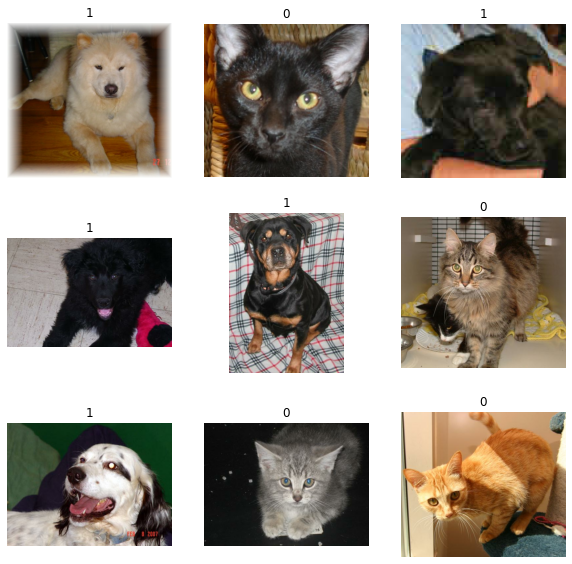

In [36]:
# 이미지를 임의로 추출하여 시각화 
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [72]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

### ResNet-34 훈련

In [23]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[20%:]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[:20%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5
1163/1163 [==============================] - 99s 85ms/step - loss: 0.6624 - accuracy: 0.6256 - val_loss: 0.6602 - val_accuracy: 0.6365
Epoch 2/5
1163/1163 [==============================] - 105s 90ms/step - loss: 0.5970 - accuracy: 0.6806 - val_loss: 0.6406 - val_accuracy: 0.6445
Epoch 3/5
1163/1163 [==============================] - 94s 81ms/step - loss: 0.5398 - accuracy: 0.7291 - val_loss: 0.5971 - val_accuracy: 0.6953
Epoch 4/5
1163/1163 [==============================] - 93s 80ms/step - loss: 0.4702 - accuracy: 0.7777 - val_loss: 0.4510 - val_accuracy: 0.7873
Epoch 5/5
1163/1163 [==============================] - 93s 80ms/step - loss: 0.4047 - accuracy: 0.8157 - val_loss: 0.6258 - val_accuracy: 0.7034


### ResNet-50 훈련

In [26]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[20%:]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[:20%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5
1163/1163 [==============================] - 170s 146ms/step - loss: 0.7183 - accuracy: 0.5739 - val_loss: 0.7333 - val_accuracy: 0.5457
Epoch 2/5
1163/1163 [==============================] - 182s 156ms/step - loss: 0.6793 - accuracy: 0.6092 - val_loss: 0.8458 - val_accuracy: 0.5535
Epoch 3/5
1163/1163 [==============================] - 170s 146ms/step - loss: 0.6835 - accuracy: 0.6022 - val_loss: 0.8385 - val_accuracy: 0.5865
Epoch 4/5
1163/1163 [==============================] - 170s 146ms/step - loss: 0.6754 - accuracy: 0.6114 - val_loss: 0.7411 - val_accuracy: 0.5672
Epoch 5/5
1163/1163 [==============================] - 170s 146ms/step - loss: 0.6643 - accuracy: 0.6205 - val_loss: 0.7103 - val_accuracy: 0.5943


### Plain-34 훈련

In [73]:
plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[20%:]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[:20%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5
1163/1163 [==============================] - 95s 82ms/step - loss: 0.7404 - accuracy: 0.5330 - val_loss: 0.8507 - val_accuracy: 0.5216
Epoch 2/5
1163/1163 [==============================] - 95s 82ms/step - loss: 0.6942 - accuracy: 0.5423 - val_loss: 0.7710 - val_accuracy: 0.5211
Epoch 3/5
1163/1163 [==============================] - 95s 82ms/step - loss: 0.6760 - accuracy: 0.5831 - val_loss: 0.6921 - val_accuracy: 0.5818
Epoch 4/5
1163/1163 [==============================] - 95s 82ms/step - loss: 0.6566 - accuracy: 0.6107 - val_loss: 0.7378 - val_accuracy: 0.5736
Epoch 5/5
1163/1163 [==============================] - 94s 81ms/step - loss: 0.6462 - accuracy: 0.6290 - val_loss: 0.7092 - val_accuracy: 0.6033


### Plain-50 훈련

In [92]:
plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[20%:]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[:20%]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5
1163/1163 [==============================] - 151s 130ms/step - loss: 0.7271 - accuracy: 0.5371 - val_loss: 0.7998 - val_accuracy: 0.5352
Epoch 2/5
1163/1163 [==============================] - 151s 130ms/step - loss: 0.7028 - accuracy: 0.5309 - val_loss: 1.2789 - val_accuracy: 0.4931
Epoch 3/5
1163/1163 [==============================] - 151s 130ms/step - loss: 0.7008 - accuracy: 0.5222 - val_loss: 0.8146 - val_accuracy: 0.5308
Epoch 4/5
1163/1163 [==============================] - 148s 127ms/step - loss: 0.7010 - accuracy: 0.5237 - val_loss: 0.7076 - val_accuracy: 0.4903
Epoch 5/5
1163/1163 [==============================] - 148s 127ms/step - loss: 0.7028 - accuracy: 0.5175 - val_loss: 0.9796 - val_accuracy: 0.5088


### 시각화
*학습을 통해 만들어진 history를 matplotlib로 시각화하여 두 모델의 검증 정확도(validation accuracy)와 검증 손실(validation loss)이 어떻게 다른지 살펴봅시다.*

###  ResNet-50 vs Plain-50

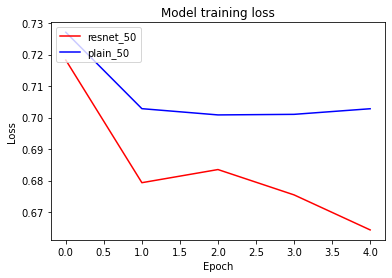

In [93]:
import matplotlib.pyplot as plt

plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')
plt.show()

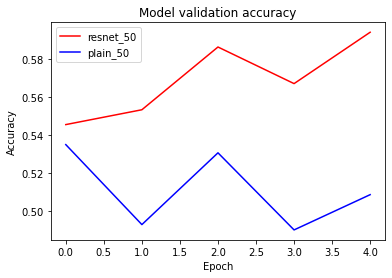

In [94]:
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')
plt.show()

### ResNet-34 vs Plain-34

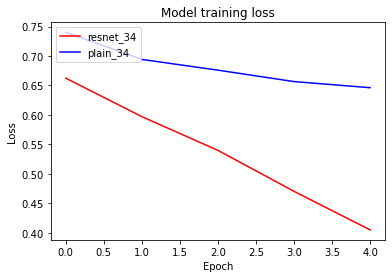

In [95]:
import matplotlib.pyplot as plt

plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')
plt.show()

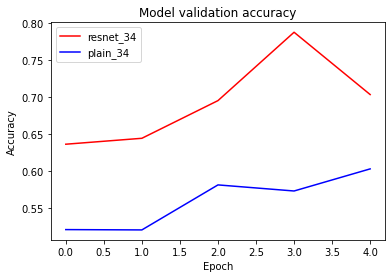

In [96]:
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')
plt.show()

residual block을 이용한 resnet이 plain모델에 비해 오류율은 낮고 정확도는 높게 나타났다. 

### 추가 실험
*시간이 남으면 아래 카탈로그를 보고, tensorflow-datasets의 지원하는 다른 데이터셋에 실험을 해봅시다.*

*Tensorflow Datasets https://www.tensorflow.org/datasets/catalog/overview*  

=> 시간인 남지 않아서 스킵하도록 한다. 

## 느낀점

ResNet Architecture를 논문 그대로 구현하는 것이 쉽지 않았다. 깊은 네트워크이다 보니 제시된 모델 summary와 비교하는 것도 일이였다.   
block 단위로 함수를 만들고, 빌드시 반복되는 구조로 모델을 생성했고, cats_vs_dogs 데이터셋으로 훈련하고 평가를 진행했다.   
VGGNet으로 진행한 이전 과정보다 224X224 로 이미지 사이즈도 커졌고, 모델도 깊어져서 그런지 훈련도중 커널이 자꾸 죽었다.   
batch사이즈와 epoch를 대폭 줄였는데, 제대로 된 훈련이 아니라 아쉬움이 남는다.  
하지만 시각화한 결과는 ResNet이 오류율이 낮고, 정확도가 높은 것으로 나왔다. 논문에서 말하고자하는 개선점인거 같다.   
레이어를 깊이 쌓았을 때 최적화가 잘 안되는 Degradation Problem 문제를 개선하고자 한 것인데, 훈련을 제대로 하면 더 눈에 띄는 결과를 확인할 수 있을거 같다.   
여러모로 아쉬움이 남지만, 논문을 스스로 구현해 본다는 것에 의미를 두고 싶다.  